# Convolutional Variational Autoencoder using Handwritten Math Symbols

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import cv2
import glob

In [2]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import os

In [3]:
top_path = '../input/handwritten-math-symbol-dataset/train/'
symbols = os.listdir(top_path)

In [4]:
idx_to_name = {i:x for (i,x) in enumerate(symbols)}
name_to_idx = {x:i for (i,x) in enumerate(symbols)}
idx_to_name

{0: 'plus cleaned',
 1: 'nine',
 2: 'eight',
 3: 'equal',
 4: 'three',
 5: 'original number',
 6: 'five',
 7: 'one',
 8: 'div',
 9: 'original sign',
 10: 'seven',
 11: 'decimal',
 12: 'four',
 13: 'zero',
 14: 'six',
 15: 'times',
 16: 'minus',
 17: 'other sign',
 18: 'two',
 19: 'other number'}

In [5]:
data = []
labels = []
dim = (28,28)

for symbol in symbols:
    path = top_path + symbol + "/*"
    imgs = [cv2.resize(cv2.imread(img, cv2.IMREAD_GRAYSCALE), dim, interpolation=cv2.INTER_AREA) for img in glob.glob(path)]
    for img in imgs:
        data.append(img)
        labels.append(name_to_idx[symbol])

In [6]:
# normalize data
data = np.array(data)
data = data / 255.0
data = data.astype('float32')
data = data.reshape(len(data), 28, 28, 1)

# one hot encoding labels
labels = np.eye(len(name_to_idx))[labels]

In [7]:
split_limit = int(len(data) - len(data) * 0.3)

In [8]:
train_images, test_images = data[:split_limit], data[split_limit:]

In [9]:
train_size = 60000
batch_size = 32
test_size = 10000

In [10]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

# VAE Architecture

<img align=left src='https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png'>

# Convolutional VAE

In [11]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=16, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=16, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

# Loss function and optimizer

In [12]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Training

In [13]:
epochs = 500
# dimensionality of the latent space
latent_dim = 2
num_examples_to_generate = 16

# random vector constant for generation
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [14]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [15]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 500, Test set ELBO: -134.59800720214844, time elapse for current epoch: 0.3635566234588623


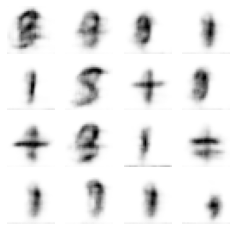

In [16]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    if(epoch % 100 == 0):
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
            .format(epoch, elbo, end_time - start_time))
        generate_and_save_images(model, epoch, test_sample)

# 2D manifold Results

In [17]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(20, 20))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

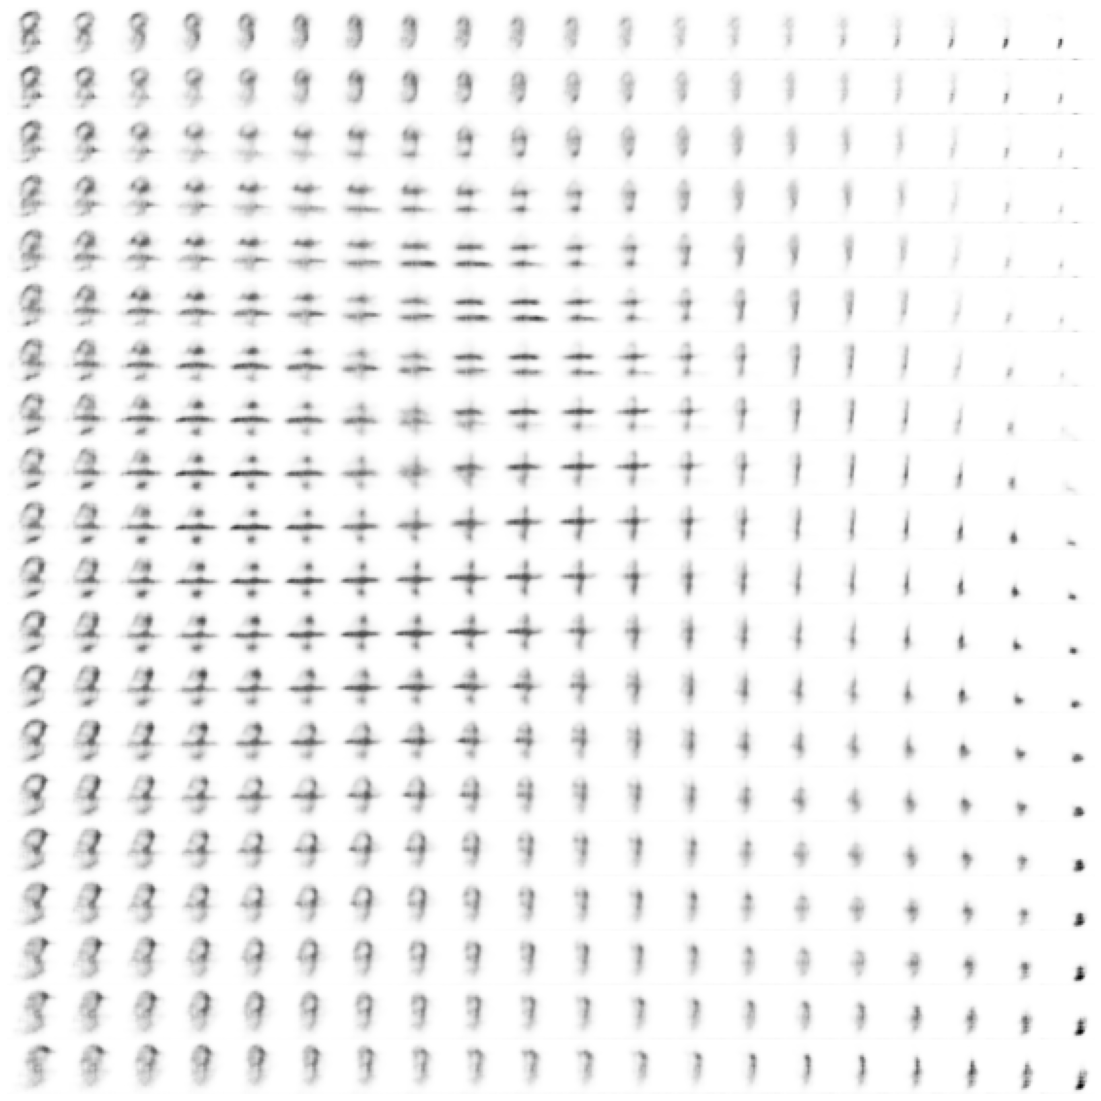

In [18]:
plot_latent_images(model, 20)